In [1]:
from models.ccmodel import CCModel
from models.rsmodel import RSModel
from models.bomodel import BOModel
from models.confi import *
from models.utilfuncs import *
from graph import *
import pandas as pd
from tqdm import tqdm
import random

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in the ECGs and labels
aucs = pd.read_csv("new_simu-data/Heart1/Heart1_AUCS.csv", header=None).to_numpy()
ecgs = pd.read_csv("new_simu-data/Heart1/Heart1_SimuData_4000.csv", header=None).to_numpy()
labels = pd.read_csv("new_simu-data/Heart1/Coord1_4000.csv", header=None).to_numpy() / 1000
uvc = pd.read_csv("new_simu-data/UVC/Coord1_UVC_4000.csv", header=None).to_numpy()

In [3]:
total_cases = 0
alle, all_points = [], []
cc_euclids = [[] for _ in range(NUM_STEPS + 21)]                    # Random init CC arrays
cc_successes, cc_avg_sites = [], []
cc_drop = []
# Set mm threshold for finding nearest
mm_thres = 200000

In [4]:
def get_random_dataset(data, coords):
    """
    Handles getting the random dataset for the randomly initialized models
    :param target_coord: target coordinate
    :param data: full dataset for a patient
    :param coords: full labels for a patient
    :return: x, y of size 4
    """
    indices = np.random.choice(range(0, data.shape[0]), NUM_POINTS_START, replace=False)
    return data[indices], coords[indices]

In [5]:
def model_run(model, x, y, train, labels, target, target_coord, target_raw, successes, avg_sites, all_euclids):
    """
    Handles running a single runthrough of a given model on a target site
    Train and labels are the initialized sets to start with (either random or by segment prediction)
    """
    # Run the training loop for the model
    euclids, preds, sites, success, nsites = model.run(x, y, train, labels, target, target_coord, target_raw)
    sites = np.asarray(sites)

    # Add to arrays if successful and add the per steps error
    if success:
        successes.append(euclids[-1])
        avg_sites.append(nsites)
    for j in range(len(euclids)):
        all_euclids[j].append(euclids[j])
        # if j != 0:
        #     drop.append(euclids[j] - euclids[j - 1])
    return successes, avg_sites, all_euclids, sites

In [6]:
cc_model = CCModel(leads=LEADS, steps=10, svr_c=SVR_C, cc=CC_THRES, cc_succ=CC_SUCC,
                   mm=mm_thres, samp_raw=ecgs, samp_coords=labels)
rs_model = RSModel(steps=NUM_STEPS, svr_c=SVR_C, samp_raw=ecgs, samp_coords=labels, cc_succ=CC_SUCC)

In [7]:
idx = np.random.randint(0,1999,1)[0]
target = aucs[idx]
target_coord = labels[idx]
target_raw = ecgs[idx]
target_uvc = uvc[idx]

# Drop the target from the training set
if idx == 0:
    x, y, raw = aucs[idx + 1:, :], labels[idx + 1:], ecgs[idx + 1:, :]
else:
    x = np.concatenate((aucs[:idx, :], aucs[idx + 1:, :]))
    y = np.concatenate((labels[:idx], labels[idx + 1:]))
    raw = np.concatenate((ecgs[:idx], ecgs[idx + 1:]))
random_x, random_y = get_random_dataset(x, y)

cc_euclids, cc_preds, cc_sites, success, num_sites = cc_model.run(x, y, random_x, random_y,
                                                         target, target_coord, target_raw)

In [8]:
lab = uvc[:,0:3]
lab.shape

(4000, 3)

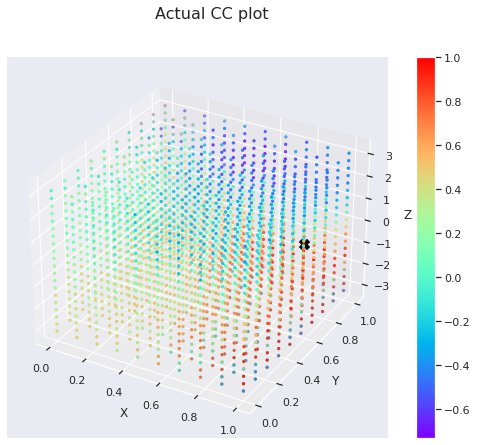

In [9]:
graph_cc_distribution(target_raw,ecgs,uvc)

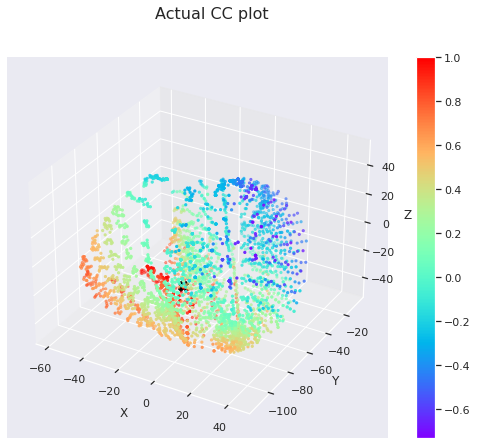

In [10]:
graph_cc_distribution(target_raw,ecgs,labels)

In [14]:
tidx = np.random.randint(0, labels.shape[0])    # Pick out a sample to use as a target
target, target_ecg,target_uvc = labels[tidx], ecgs[tidx], uvc[tidx]
print("Target: ", target)
init = 5 #initial random sample
steps = 5 # total AL step
af = "ucb" 

Target:  [  -5.66455 -105.614     -0.17927]


In [17]:

def black_box(x, y, z):
    """
    Represents a black box function to maximize for CC of two ECGs given an XYZ coordinate
    :param x:
    :param y: coordinates of the prediction
    :param z:
    :return: CC of that point and the target
    """
    sample_ecg = ecgs[get_index(np.array([x, y, z]),labels)]
    return abs(correlation_coef(target_ecg, sample_ecg))

In [21]:
import pandas as pd
import numpy as np
from data_analysis import get_heart_bounds, correlation_coef, graph_3d, get_index
from graph import *
from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
# from prettytable import PrettyTable

labels = uvc[:,0:3]
bounds = get_heart_bounds(labels) # getting bounds 
print("Target: ", target_uvc)

optimizer = BayesianOptimization(f=black_box,pbounds=bounds,random_state=None, real_set=labels)
gp,X = optimizer.gpfit(init_points=init, n_iter=steps,  acq=af, kappa = 1,kappa_decay=0.75,kappa_decay_delay=2)

Target:  [0.22222222 0.33333333 0.82631579 1.         0.         0.05      ]
|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.1583   |  1.0      |  0.7778   | -1.157    |
|  2        |  0.5489   |  0.5556   |  0.3333   |  2.809    |
|  3        |  0.1034   |  0.7778   |  0.3333   | -0.8263   |
|  4        |  0.8677   |  0.5556   |  0.0      | -0.1653   |
|  5        |  0.3189   |  0.6667   |  0.0      |  0.8263   |
|  6        |  0.5489   |  0.6667   |  0.3333   |  2.809    |
|  7        |  0.5141   |  0.5556   |  0.4444   |  2.809    |
|  8        |  0.8949   |  0.4444   |  0.0      | -0.1653   |
|  9        |  0.9092   |  0.3333   |  0.0      | -0.1653   |
|  10       |  0.313    |  0.2222   |  0.0      |  0.1653   |


In [33]:
def predicted_visited2(init,target,target_ecg,labels,ecgs,visited,predicted):
    """
    show the points and path of both predicted and visited values
    """
    color_gradient = []
    for ecg, coord in zip(ecgs, labels):
        cc = correlation_coef(target_ecg, ecg)
        color_gradient.append(cc)
        
    path_pred = np.array(predicted)
    path = np.array(visited)
    path1 = path[0:init,:]
    path2 = path[init:len(path),:]
    
#     rest = np.delete(labels, np.where(np.isin(labels, path2)), axis=0)
#     color_gradient = np.delete(color_gradient, np.where(np.isin(labels, path2)), axis=0)
    fig = plt.figure(figsize=(10,7))
    ax = fig.gca(projection='3d')
    img = ax.scatter(xs=labels[:, 0], ys=labels[:, 1], zs=labels[:, 2], zdir='z', alpha=0.75,s = 5, c=color_gradient, cmap = plt.cm.rainbow)
    ax.scatter(xs=path2[:, 0], ys=path2[:, 1], zs=path2[:, 2], zdir='z',s=20, color='blue')
    ax.scatter(xs=path_pred[:, 0], ys=path_pred[:, 1], zs=path_pred[:, 2], zdir='z',s=20, color='green')
    ax.plot(path2[:, 0], path2[:, 1], path2[:, 2], color = 'black',label = 'Visited Path')
    ax.plot(path_pred[:, 0], path_pred[:, 1], path_pred[:, 2], color = 'red',label='Predicted Path')
    ax.legend()
    fig.colorbar(img)
    m = path2
    n = path_pred
    for i in range(len(m)):
        ax.text(m[i, 0], m[i, 1], m[i, 2], '%s' % (str(i+init+1)), size=10, zorder=1, color='black')
        ax.text(n[i, 0], n[i, 1], n[i, 2], '%s' % (str(i+init+1)), size=10, zorder=1, color='red')
    ax.scatter(xs=target[0], ys=target[1], zs=target[2], color='black',marker = "*", s = 150)
    fig.suptitle('Path of BO to target', fontsize=16)
    plt.show()

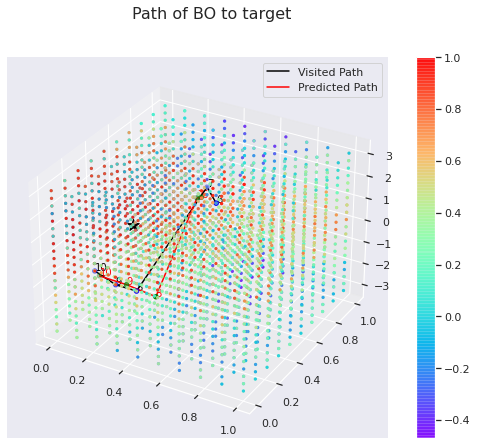

In [34]:
predicted_visited2(init,target_uvc,target_ecg,labels,ecgs,optimizer.visited,optimizer.predicted)

In [30]:
color_gradient = []
for ecg, coord in zip(ecgs, labels):
    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)

In [32]:
len(color_gradient)

4000